#  A Recommender System for Restaurants in Philadelphia

In this project, we aim to develop a recommender system for restaurants in Philadelphia using Yelp business and review data. The system will leverage this dataset to generate personalized restaurant recommendations for users based on their preferences and past dining experiences. By analyzing factors such as cuisine type, price range, location, and user reviews, the recommender system will help users discover new dining options and make informed decisions when choosing restaurants in Philadelphia.

Through this project, we aim to create a valuable resource for residents and visitors of Philadelphia, making their restaurant selection process more enjoyable and convenient. The recommender system will serve as a trusted guide, helping users navigate the city's diverse dining landscape and discover hidden culinary gems while catering to their individual preferences.


<div style="display: flex;">
    <img src="images/philadelphia.jpg" alt="Image 1" style="width: 45%; padding-right: 5px; display: inline-block;">
    <img src="images/restaurant.jpg" alt="Image 2" style="width: 45%; display: inline-block;">
</div>

images source:https://unsplash.com/




## Exploring the data

In [2]:
import sys
sys.path.append('/home/ch3370/ds/env/lib/python3.8/site-packages')
print(sys.path)
import numpy as np
import pandas as pd
import json
import psutil
import matplotlib.pyplot as plt

['/home/ch3370/ds/capstone', '/home/ch3370/miniconda3/lib/python38.zip', '/home/ch3370/miniconda3/lib/python3.8', '/home/ch3370/miniconda3/lib/python3.8/lib-dynload', '', '/home/ch3370/miniconda3/lib/python3.8/site-packages', '/home/ch3370/ds/env/lib/python3.8/site-packages']


## Business data
Loading Yelp business data and filter only the businesses in Philadelphia.

In [3]:
df_buzi = pd.read_json('yelp_data/yelp_academic_dataset_business.json',lines=True)
df_buzi = df_buzi[df_buzi['city']=='Philadelphia']
df_buzi.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

#### Get all categories of businesses that have 'Food' , 'Bars', and 'Restaurants'.

In [4]:
restaurant_idx = df_buzi['categories'].apply(lambda x:('Food' in x.split(', ') or 'Restaurants' in x.split(', ')
                                                      or 'Bars' in x.split(', ')) 
                            if x is not None else False)
restaurant_idx.sum()

7349

In [5]:
df_restaurant = df_buzi[restaurant_idx]
df_restaurant = df_restaurant[df_restaurant['is_open']==1]
categories = df_restaurant['categories'].apply(lambda x:x.split(', ')).explode().value_counts(ascending=False)
categories = categories[categories>5]
categories.keys()

Index(['Restaurants', 'Food', 'Nightlife', 'Bars', 'Coffee & Tea',
       'Sandwiches', 'Pizza', 'American (Traditional)', 'Breakfast & Brunch',
       'American (New)',
       ...
       'Polish', 'Fish & Chips', 'Vape Shops', 'Eatertainment', 'Hawaiian',
       'Museums', 'Performing Arts', 'Live/Raw Food', 'Creperies',
       'Wholesale Stores'],
      dtype='object', name='categories', length=212)

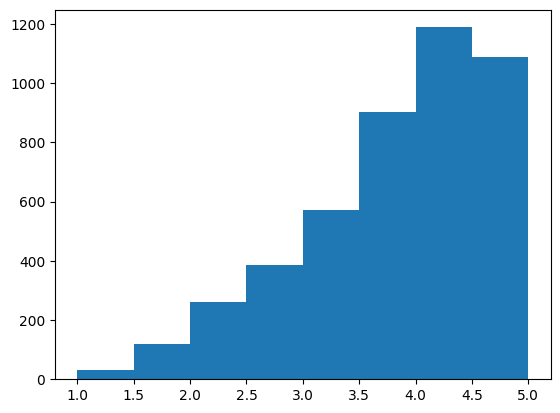

In [70]:
plt.hist(df_restaurant['stars'],bins=8);

#### get averages for some categories

/tmp/ipykernel_15754/4034904659.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels= cate_means.keys()[:5],rotation=45)
/tmp/ipykernel_15754/4034904659.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels= cate_means.keys()[-5:],rotation=45)


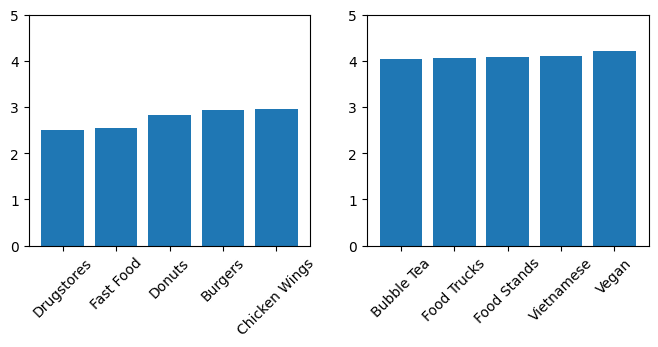

In [39]:
df_restaurant_exploded = df_restaurant.copy()
df_restaurant_exploded.categories = df_restaurant_exploded.categories.apply(lambda x:x.split(', '))
df_restaurant_exploded = df_restaurant_exploded.explode('categories')
cate_count = df_restaurant_exploded.groupby('categories').business_id.count()
cate_means = df_restaurant_exploded.groupby('categories').stars.mean()[cate_count>50]
cate_means = cate_means.sort_values()
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].bar(cate_means.keys()[:5],cate_means.values[:5])
ax[0].set_xticklabels(labels= cate_means.keys()[:5],rotation=45)
ax[0].set_ylim(0,5)
ax[1].bar(cate_means.keys()[-5:],cate_means.values[-5:])
ax[1].set_xticklabels(labels= cate_means.keys()[-5:],rotation=45)
ax[1].set_ylim(0,5);

#### Visualize the restaurants of different categories on map

In [65]:
filtered_index = df_restaurant_exploded.groupby('categories').count()['business_id'] > 50
categories_to_show = df_restaurant_exploded.groupby('categories').count()['name'][filtered_index].keys()
import ipywidgets as widgets
from IPython.display import display
import folium
dropdown = widgets.Dropdown(
    options=categories_to_show,
    value=categories_to_show[0],
    description='Category:',
    disabled=False
)
def update_map(category):
    filtered_df = df_restaurant_exploded[df_restaurant_exploded['categories']==category]
    m = folium.Map(location=[39.9526, -75.1652],zoom_start=13)
    for _, row in filtered_df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        folium.Marker([lat,lon],popup='name: {}\n rating:{}'.format(row['name'],row['stars'])).add_to(m)
    display(m)
# display(dropdown)
widgets.interactive(update_map,category=dropdown)

interactive(children=(Dropdown(description='Category:', options=('American (New)', 'American (Traditional)', '…

## Review data
Get review data on restaurants in Philadelphia

In [61]:
# df_rev = pd.read_json('yelp_data/yelp_academic_dataset_review.json',lines=True)
# res_rev = pd.merge(df_restaurant,df_rev,on='business_id',how='inner')
# res_rev.to_csv('yelp_data/processed_rev_buz.csv',index=False)

In [7]:
res_rev = pd.read_csv('yelp_data/processed_rev_buz.csv')
res_rev = res_rev.rename(columns={'stars_x':'stars_res','stars_y':'stars_rev'})
res_rev.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_res', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id',
       'stars_rev', 'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

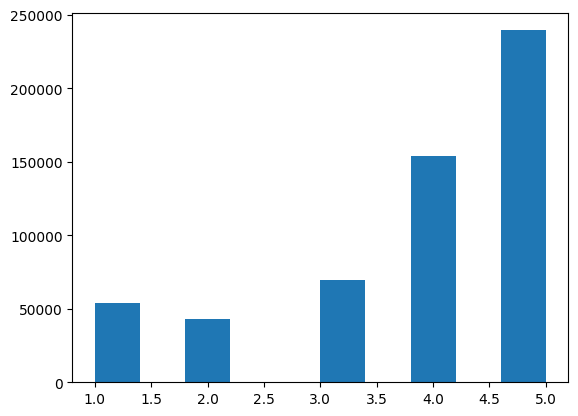

In [72]:
plt.hist(res_rev['stars_rev']);

## Build Models

In [1]:
from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse
from surprise.model_selection.search import GridSearchCV

In [103]:
all_users = res_rev.user_id.unique()
all_restaurants = res_rev.business_id.unique()
all_users_dic = {user_id:index for index, user_id in enumerate(all_users)}
all_restaurants_dic = {restaurant_id:index for index, restaurant_id in enumerate(all_restaurants)}

#### Collaborative filtering using SVD

In [118]:
train_data = res_rev[['business_id','user_id','stars_rev']].copy()
train_data['business_id'] = train_data['business_id'].apply(lambda x:all_restaurants_dic[x]) 
train_data['user_id']     = train_data['user_id'].apply(lambda x:all_users_dic[x])
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train_data
                            ,reader)
trainset = data.build_full_trainset()

In [126]:

param_grid = {
    'n_factors': [50, 100, 200],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.5]
}
grid_search = GridSearchCV(SVD,param_grid,measures=['RMSE','MAE'],cv=3,refit=True,joblib_verbose=1)
grid_search.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 28.5min finished


In [127]:
best_params = grid_search.best_params
best_score = grid_search.best_score
print(best_params)
print(best_score)

{'rmse': {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}}
{'rmse': 1.1660797800573663, 'mae': 0.9199249377408923}


#### Collaborative filtering using NMF

In [128]:
param_grid = {
    'n_factors': [10, 20, 30],
    'n_epochs': [10, 20, 30],
    'biased' : [True, False]
}
grid_search = GridSearchCV(NMF,param_grid,measures=['RMSE','MAE'],cv=3,refit=True,joblib_verbose=1)
grid_search.fit(data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.0min finished


In [129]:
best_params = grid_search.best_params
best_score = grid_search.best_score
print(best_params)
print(best_score)

{'rmse': {'n_factors': 20, 'n_epochs': 30, 'biased': False}, 'mae': {'n_factors': 20, 'n_epochs': 20, 'biased': False}}
{'rmse': 1.3200321402290296, 'mae': 0.9855461666289179}


In [130]:
kwargs = {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
model = SVD(**kwargs)
model.fit(trainset)

In [120]:
from surprise.dump import dump
model_file = 'model/trained_model_svd.pkl'
dump(model_file,algo=model)

In [111]:
import pickle
with open('processed_data/categories_to_show.pkl','wb') as file:
    pickle.dump(categories_to_show,file)
df_restaurant_exploded.to_csv('processed_data/df_restaurant_exploded.csv',index=False)
with open('processed_data/all_users.pkl','wb') as file:
    pickle.dump(all_users,file)
with open('processed_data/all_users_dic.pkl','wb') as file:
    pickle.dump(all_users_dic,file)   
with open('processed_data/all_restaurants_dic.pkl','wb') as file:
    pickle.dump(all_restaurants_dic,file)   